# Temporal Difference (TD) Methods

the root of this is to measure the value of the next state against the current value and reward as the td error.



# TD Prediction

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

we will use the frozen lake env in gym to play with this algo

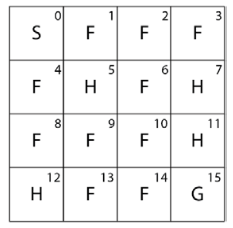

In [1]:
import gym
import pandas as pd
import numpy as np

In [2]:
#create env and reset to show output sample
env = gym.make('FrozenLake-v1')
print(env.reset())

(0, {'prob': 1})


In [3]:
#define random policy for the prediction
def random_policy(env):
    #selects random action from env action space
    return env.action_space.sample()

In [4]:
#function to run some experiments
def experimental_run(env, policy, alpha, gamma, n_episodes = 50000):
    """
    simple function to run experiments
    runs thru the environment taking random actions to clock rewards
    
    inputs:
    env - openai gym environment
    policy - policy to select actions (random in this scenario)
    gamma - discount factor to apply to calculate state values
    n_episodes - number of episodes to complete
    
    output
    pandas df with resulting state values
    """
    #set up value tracking object
    V = {}
    for s in range(env.observation_space.n):
        V[s]=0.0
        
    for i in range(n_episodes):
        state = env.reset()[0]
        
        done = 0
        
        while not done:
            a = random_policy(env)
            next_state, reward, done, info, other = env.step(a)
            
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            
            state = next_state          

    return pd.DataFrame(list(V.items()), columns=['state', 'value'])
    

In [5]:
df = (experimental_run(env = env, 
                       policy = random_policy, 
                       alpha = 0.85, 
                       gamma = 0.95, 
                       n_episodes = 50000))

df
      

,state,value
0,0,1.574670e-05
1,1,2.397093e-06
2,2,9.570621e-05
3,3,1.867236e-08
4,4,2.672794e-05
5,5,0.000000e+00
6,6,6.231824e-04
7,7,0.000000e+00
8,8,6.889336e-04
9,9,5.275190e-03


## findings

the value from state 14 and 13 is high since we need to hit that state to land in the goal!

# TD Control SARSA

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

turns into state and action with:

Q(𝑠, a) = Q(𝑠, a) + 𝛼(𝑟 + 𝛾Q(𝑠', a') − Q(𝑠, a))

this is the sarsa on-policy control algorithm

we seek to control our agent now rather than select random actions

we will use the frozen lake env in gym to play with this algo

and of course to balance explore and exploit an epsilon greedy selection of optimal actions

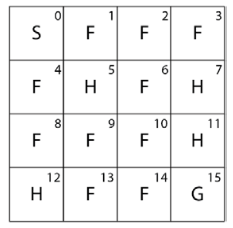

In [6]:
env = gym.make('FrozenLake-v1')

In [7]:
print(env.reset())

(0, {'prob': 1})


In [8]:
def epsilon_greedy(state, epsilon, Q, env):
    """
    epsilon greedy policy for agent to follow
    selects action from state-action space
    
    input
    state - current state agent is in
    epislon - probability of chosing non optimal/random action
    Q - state action value dict
    env - openai gym env
    
    output
    integer represnting the action to select
    """
    if np.random.uniform(0,1) < epsilon:
        #selects random action from env action space
        return env.action_space.sample()
    else:
        #selects action with highest value from state action space
        return np.argmax(Q[state])
    

In [9]:
def experimental_sarsa_run(env, policy, alpha, gamma, epsilon, n_episodes = 50000):
    """
    simple function to run experiments
    runs thru the environment taking random actions to clock rewards
    this function utilizes the sarsa algorithm
    
    inputs:
    env - openai gym environment
    policy - policy to select actions (random in this scenario)
    alpha - step size for adjusting state-action values
    gamma - discount factor to apply to calculate state values
    epsilon - float number which dictates what % of the time that a non optimal and random action is selected
    n_episodes - number of episodes to complete
    
    output
    pandas df with resulting state-action values
    dict representing the q object of state action values
    """
    #init Q to all zeros
    Q = {}
    temp = [0 for a in range(env.action_space.n)]
    for s in range(env.observation_space.n):
        Q[s] = temp.copy()
        
    #play thru each episode and learn
    for i in range(n_episodes):
        done = 0
        
        state = env.reset()[0]
        
        action = policy(state, epsilon, Q, env)    
        
        #run thru single episode until terminal state
        while not done:
            
            next_state, reward, done, info, other = env.step(action)
            
            next_action = policy(next_state, epsilon, Q, env)
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] -  Q[state][action])
            
            state = next_state
            action = next_action

                
    return pd.DataFrame(list(Q.items()), columns=['state', 'action_values']), Q                                  
                                         

In [10]:
df, sarsa_q = (experimental_sarsa_run(env = env, 
                               policy = epsilon_greedy, 
                               alpha = 0.85, 
                               gamma = 0.95, 
                               epsilon = 0.10,
                               n_episodes = 50000))

df
      

,state,action_values
0,0,"[0.0010660135103901232, 0.0008103777603892092,..."
1,1,"[0.00019529947338908348, 7.32084263432566e-05,..."
2,2,"[0.00037874706274339254, 0.0014874838879147436..."
3,3,"[0.0002716299584893387, 0.00046928983126712454..."
4,4,"[0.000937822011796245, 0.000639669647897113, 0..."
5,5,"[0, 0, 0, 0]"
6,6,"[1.3134650074480847e-06, 2.677827167099124e-05..."
7,7,"[0, 0, 0, 0]"
8,8,"[0.0004210996701782513, 0.003231703214399417, ..."
9,9,"[1.0566991442584403e-05, 0.5403293384811654, 0..."


# TD Control Q-learning

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

turns into state and action with:

Q(𝑠, a) = Q(𝑠, a) + 𝛼(𝑟 + 𝛾 max[Q(𝑠', a')] − Q(𝑠, a))

this is the q-learing off-policy control algorithm

we will use the frozen lake env in gym to play with this algo

and of course to balance explore and exploit an epsilon greedy selection of optimal actions

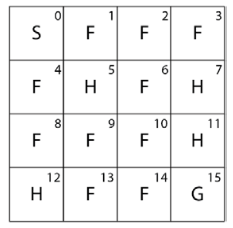

In [11]:
def experimental_q_run(env, policy, alpha, gamma, epsilon, n_episodes = 50000):
    """
    simple function to run experiments
    runs thru the environment taking random actions to clock rewards
    this function utilizes the q-learning algorithm
    
    inputs:
    env - openai gym environment
    policy - policy to select actions (random in this scenario)
    alpha - step size for adjusting state-action values
    gamma - discount factor to apply to calculate state values
    epsilon - float number which dictates what % of the time that a non optimal and random action is selected
    n_episodes - number of episodes to complete
    
    output
    pandas df with resulting state-action values
    dict representing the q object of state action values
    """
    #init Q to all zeros
    Q = {}
    temp = [0 for a in range(env.action_space.n)]
    for s in range(env.observation_space.n):
        Q[s] = temp.copy()
        
    for i in range(n_episodes):
        done = 0
        
        state = env.reset()[0]
        
        while not done:
            
            action = policy(state, epsilon, Q, env)
            
            next_state, reward, done, info, other = env.step(action)            
                        
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) -  Q[state][action])
            
            state = next_state
                
    return pd.DataFrame(list(Q.items()), columns=['state', 'action_values']), Q                                  
                                         

In [12]:
df, q_q = (experimental_q_run(env = env, 
                               policy = epsilon_greedy, 
                               alpha = 0.85, 
                               gamma = 0.95, 
                               epsilon = 0.10,
                               n_episodes = 50000))

df
      

,state,action_values
0,0,"[0.13091000691042493, 0.12172158047711044, 0.1..."
1,1,"[0.11567923607700722, 0.02009573653772423, 0.0..."
2,2,"[0.0032662912308192233, 0.0702612661209853, 0...."
3,3,"[0.012841816919896512, 0.001444723937165793, 0..."
4,4,"[0.4625639020899872, 0.03674826659999997, 0.03..."
5,5,"[0, 0, 0, 0]"
6,6,"[0.001037945498434164, 2.812401894196386e-05, ..."
7,7,"[0, 0, 0, 0]"
8,8,"[0.12677372281212532, 0.012353239240241412, 0...."
9,9,"[0.0022750641144297003, 0.5541325128969349, 0...."


# comparison of output q tables

create a function to run thru the frozen lake env and show outcomes over 1000 episodes using the supplied q objects using a purely greedy policy


In [13]:
import matplotlib.pyplot as plt

def greedy_policy(q, state):
    #returns greedy action give q state-action value object
    return np.argmax(q[state])

def run_episode(q, policy, env):
    #runs an episode to completion and returns the reward
    done = 0
    total_reward = 0
    state = env.reset()[0]
    while not done:
        action = policy(q, state)
        state, reward, done, info, other = env.step(action)
        total_reward += reward 
        
    return total_reward

def compare_q(env, q_q, sarsa_q, policy, n_episodes = 1000):
    """
    takes two trained q objects to compare sarsa to q-learning
    
    inputs
    env - openai gym env obj
    q_q - q object trained using q learning
    sarsa_q -  q object trained using sarsa
    n_epsiodes - number of epsiodes to run with each q object taking greedy action
    """
    q_scores = []
    sarsa_scores = []
    
    for i in range(n_episodes):
        q_scores.append(run_episode(q_q, policy, env))
        sarsa_scores.append(run_episode(sarsa_q, policy, env))
        
    
    #plot scores
    print("avg q score :", np.mean(q_scores))
    print("avg sarsa score :", np.mean(sarsa_scores))
    
    plt.plot(q_scores, label = 'q scores')
    plt.plot(sarsa_scores, label = 'sarsa scores')  
    plt.title('score over experiment runs')
    plt.legend()
    plt.show()    

avg q score : 0.674
avg sarsa score : 0.255


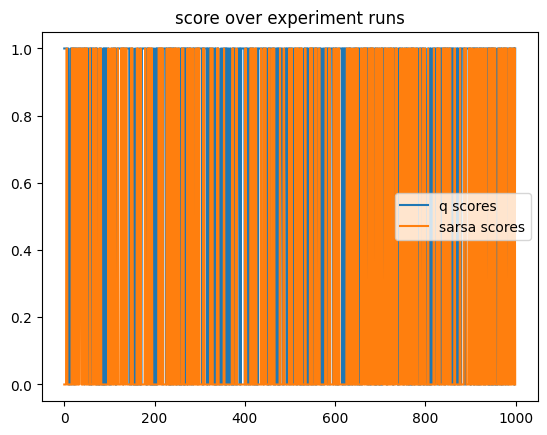

In [14]:
compare_q(env, q_q, sarsa_q, greedy_policy, n_episodes = 1000)

# findings

scores can fluctuate wildly in a random markov chain env like frozen lake!

generally q learning does better long term with learning in this environment given the better overall score.